In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import torch
from torch import nn
from torchmetrics.classification import MulticlassJaccardIndex
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from shapely.geometry import Polygon

# EDA

In [2]:
with open('data/meta.json', 'r') as f:
    meta_json = json.load(f)

classes = meta_json['classes']
num_classes = len(classes)

<Figure size 1500x500 with 0 Axes>

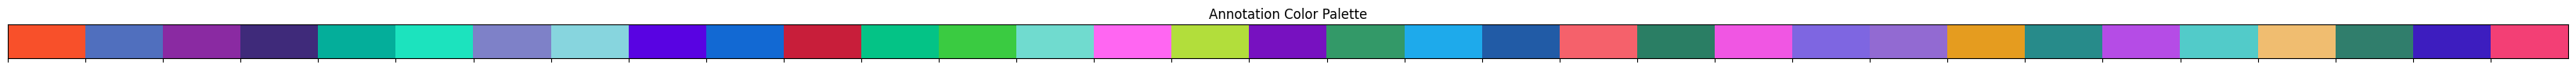

In [3]:
# Extract class details
class_titles = [cls['title'] for cls in classes]
class_colors = [cls['color'] for cls in classes]

# Visualization
plt.figure(figsize=(15, 5))

# Color palette visualization
sns.palplot(class_colors)
plt.title('Annotation Color Palette')

plt.tight_layout()
plt.show()

In [4]:
class AnnotationProcessor:
    def __init__(self, annotation_dir: str):
        """
        Process annotation files for teeth segmentation dataset
        
        Args:
            annotation_dir (str): Directory containing annotation JSON files
        """
        self.annotation_dir = annotation_dir
        self.annotations = self._load_annotations()
    
    def _load_annotations(self) -> list[dict]:
        """
        Load all annotation files from directory
        
        Returns:
            list[dict]: Parsed annotation files
        """
        annotations = []
        for filename in os.listdir(self.annotation_dir):
            if filename.endswith('.json'):
                with open(os.path.join(self.annotation_dir, filename), 'r') as f:
                    annotations.append(json.load(f))
        return annotations
    
    def analyze_annotations(self) -> dict:
        """
        Analyze dataset annotation characteristics
        
        Returns:
            dict: Comprehensive annotation statistics
        """
        class_counts = {}
        polygon_stats = {
            'point_counts': [],
            'polygon_areas': []
        }
        
        for annotation in self.annotations:
            for obj in annotation.get('objects', []):
                class_title = obj['classTitle']
                class_counts[class_title] = class_counts.get(class_title, 0) + 1
                
                # Polygon analysis
                points = np.array(obj['points']['exterior'])
                polygon = Polygon(points)
                
                polygon_stats['point_counts'].append(len(points))
                polygon_stats['polygon_areas'].append(polygon.area)
        
        return {
            'total_images': len(self.annotations),
            'class_distribution': class_counts,
            'polygon_stats': {
                'avg_points': np.mean(polygon_stats['point_counts']),
                'avg_area': np.mean(polygon_stats['polygon_areas'])
            }
        }

In [5]:
# Example Usage
annotation_processor = AnnotationProcessor('data/d2/ann')
analysis = annotation_processor.analyze_annotations()
print(analysis['total_images'])
print(analysis['class_distribution'])
print(analysis['polygon_stats'])

598
{'32': 317, '31': 428, '30': 358, '29': 518, '28': 559, '27': 590, '26': 582, '25': 581, '24': 575, '23': 584, '22': 588, '21': 548, '20': 515, '19': 361, '18': 420, '17': 323, '15': 503, '14': 446, '13': 442, '12': 465, '11': 536, '10': 511, '9': 519, '8': 518, '7': 508, '6': 535, '5': 452, '4': 448, '3': 448, '2': 487, '1': 332, '16': 321}
{'avg_points': np.float64(15.904295599947774), 'avg_area': np.float64(11618.948132915524)}


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32')])

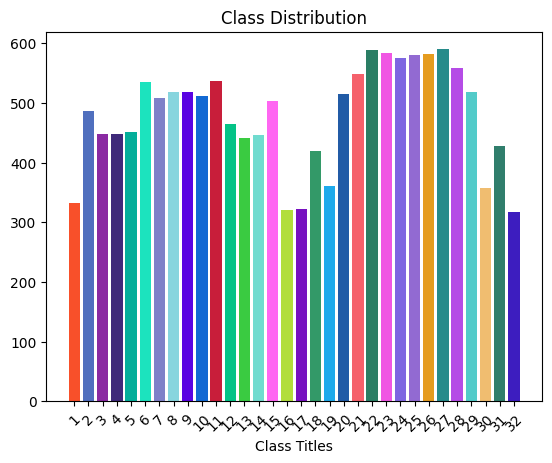

In [6]:
sorted_data = dict(sorted(analysis['class_distribution'].items(), key=lambda x: int(x[0])))

plt.bar(sorted_data.keys(), sorted_data.values(), color=class_colors)
plt.title('Class Distribution')
plt.xlabel('Class Titles')
plt.xticks(rotation=45)

In [54]:
from utils import hex_to_rgb


with open("meta.json", "r") as json_file:
    meta_json = json.load(json_file)
    print({
        class_item["title"]: hex_to_rgb(class_item["color"])
        for class_item in classes
    })

{'13': (248, 80, 42), '14': (80, 111, 190), '15': (138, 42, 162), '11': (63, 42, 122), '12': (4, 174, 154), '19': (28, 227, 190), '20': (126, 129, 200), '21': (135, 213, 222), '22': (89, 3, 226), '23': (18, 105, 211), '24': (200, 30, 58), '25': (4, 195, 134), '27': (58, 203, 65), '32': (112, 219, 207), '16': (255, 102, 242), '26': (178, 222, 59), '17': (119, 17, 192), '1': (51, 153, 104), '2': (30, 170, 235), '3': (33, 91, 166), '4': (245, 97, 107), '5': (42, 126, 100), '6': (240, 86, 227), '7': (126, 102, 225), '8': (146, 106, 210), '9': (229, 156, 31), '10': (39, 139, 138), '18': (181, 76, 230), '28': (82, 203, 201), '29': (240, 189, 112), '30': (48, 126, 108), '31': (61, 29, 191), '13(polygon)': (243, 63, 117)}


# Training

In [61]:
from teeth_dataset import TeethSegmentationDataset

class TeethSegmentationDataModule(pl.LightningDataModule):
    def __init__(self, img_dir, ann_dir, batch_size=32, num_workers=4):
        super().__init__()
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        full_dataset = TeethSegmentationDataset(self.img_dir, self.ann_dir)
        
        train_size = int(0.7 * len(full_dataset))
        val_size = int(0.15 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=int(self.batch_size/2), 
                          num_workers=self.num_workers, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=int(self.batch_size/2), 
                          num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=int(self.batch_size/2), 
                          num_workers=self.num_workers)

In [8]:
# Define a double convolution block
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes=32):
        super(UNet, self).__init__()

        self.encoder1 = double_conv(1, 64)
        self.encoder2 = double_conv(64, 128)
        self.encoder3 = double_conv(128, 256)
        self.encoder4 = double_conv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = double_conv(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final(dec1)

# Define the LightningModule
class UNetLightning(pl.LightningModule):
    def __init__(self, num_classes=32):
        super(UNetLightning, self).__init__()
        self.model = UNet()
        self.criterion = nn.CrossEntropyLoss()
        self.iou_metric = MulticlassJaccardIndex(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.long())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.long())
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.long())
        iou = self.iou_metric(outputs.argmax(dim=1), masks)
        self.log("test_loss", loss)
        self.log("test_iou", iou)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [9]:
# Initialize data module
dm = TeethSegmentationDataModule(
    img_dir='data/d2/img',
    ann_dir='data/d2/ann'
)

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger

# Model
model = UNetLightning()

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='teeth-seg-{epoch:02d}-{val_loss:.2f}'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=True,
    mode='min'
)

# Logger
mlflow_logger = MLFlowLogger(
    experiment_name='teeth_segmentation',
    tracking_uri='./mlruns'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',
    precision=16,
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=mlflow_logger
)

/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
# Train
trainer.fit(model, dm)


  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | UNet                   | 31.0 M | train
1 | criterion  | CrossEntropyLoss       | 0      | train
2 | iou_metric | MulticlassJaccardIndex | 0      | train
--------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.130   Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 27/27 [00:52<00:00,  0.52it/s, v_num=84b1]

Metric val_loss improved. New best score: 1.309


Epoch 1: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.315 >= min_delta = 0.001. New best score: 0.994


Epoch 2: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.140 >= min_delta = 0.001. New best score: 0.854


Epoch 3: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.141 >= min_delta = 0.001. New best score: 0.713


Epoch 4: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.697


Epoch 5: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.694


Epoch 6: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.684


Epoch 7: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.680


Epoch 8: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.676


Epoch 9: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.675


Epoch 10: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.673


Epoch 12: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.663


Epoch 13: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.657


Epoch 14: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.650


Epoch 15: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.644


Epoch 16: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.627


Epoch 17: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.607


Epoch 20: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.597


Epoch 21: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.554


Epoch 22: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.535


Epoch 23: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.519


Epoch 24: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.510


Epoch 25: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.499


Epoch 26: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.485


Epoch 28: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.479


Epoch 29: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.471


Epoch 30: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.459


Epoch 31: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.440


Epoch 32: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.438


Epoch 33: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.429


Epoch 34: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.402


Epoch 36: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.362


Epoch 37: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.351


Epoch 39: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.331


Epoch 40: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.321


Epoch 41: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.309


Epoch 42: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.292


Epoch 44: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.269


Epoch 45: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.263


Epoch 49: 100%|██████████| 27/27 [01:13<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.248


Epoch 50: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.242


Epoch 54: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.237


Epoch 55: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.224


Epoch 58: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.223


Epoch 60: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.219


Epoch 65: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.219. Signaling Trainer to stop.


Epoch 65: 100%|██████████| 27/27 [01:12<00:00,  0.37it/s, v_num=84b1]


In [12]:
# Test
trainer.test(model, dm)

/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/almondheng/teeth-segmentation/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Testing DataLoader 0: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_iou            0.4212079346179962
        test_loss           0.19843250513076782
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19843250513076782, 'test_iou': 0.4212079346179962}]

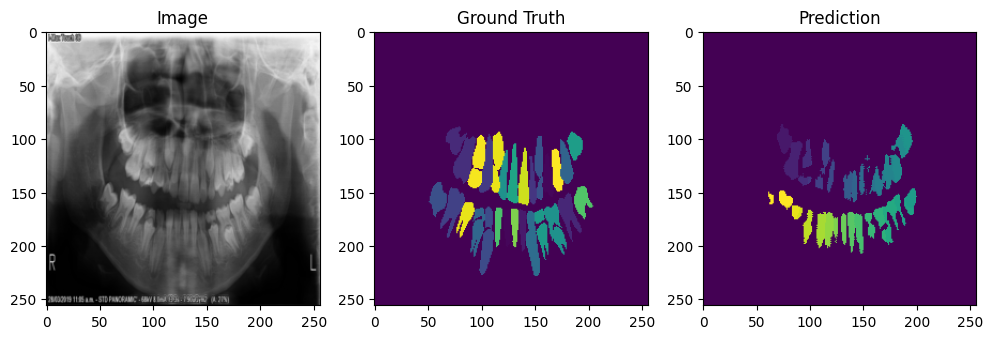

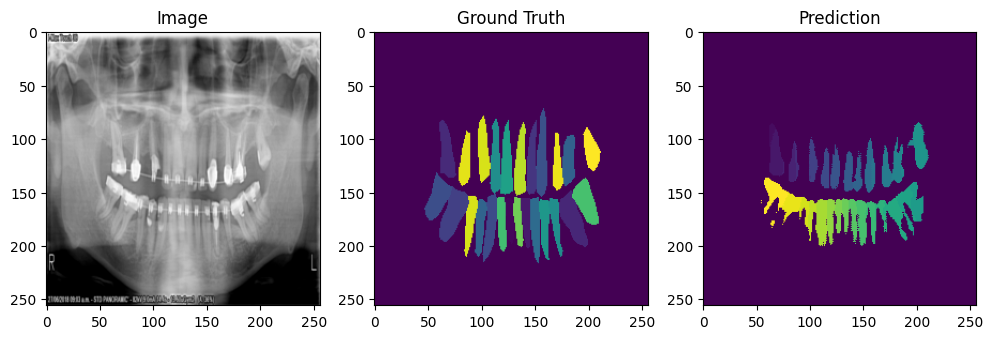

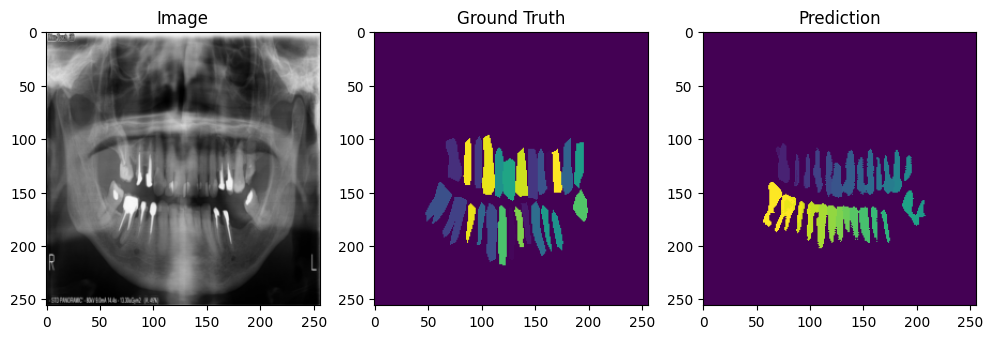

In [59]:
model.eval()

num_samples = 3
with torch.no_grad():
    for i, (images, masks) in enumerate(dm.test_dataloader()):
        if i >= num_samples:
            break
        outputs = model(images).argmax(dim=1)

        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(images[0][0].cpu(), cmap="gray")

        # Ground truth mask with class colors
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        mask_gt = masks[0].cpu().numpy()

        plt.imshow(mask_gt)

        # Predicted mask with class colors
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        output_pred = outputs[0].cpu().numpy()

        plt.imshow(output_pred)

        plt.show()